# Working with Map Projections

## Managing Coordinate Reference Systems in Python

In Chapter 5, we learned how the Coordinate Reference System (CRS) ultimately describes how geometries are related to the places on Earth and what are the core components of a CRS. Our main tool for managing coordinate reference systems is the [PROJ library](https://proj.org/) [^proj] which can be used through the [pyproj Python library](https://pyproj4.github.io/pyproj/stable/) [^pyproj]. `Pyproj` can be used to access the CRS information of a given geographic dataset and also for reprojecting the data from one coordinate system to another. In the following, we will demonstrate how to work with coordinate reference systems in `geopandas` by using a country border dataset from Europe. We will reproject the dataset from the original WGS84 coordinate system into a Lambert Azimuthal Equal Area projection which is the projection EU [recommends for Europe](http://mapref.org/LinkedDocuments/MapProjectionsForEurope-EUR-20120.pdf) [^EU_projection].

Let's start by reading the data from the `eu_countries_2022.gpkg` file. When reading the data into `GeoDataFrame` with `geopandas`, the CRS information is automatically read from the datafile and stored into the `.crs` attribute:

In [11]:
import geopandas as gpd

# Read the file
fp = "data/EU_countries/eu_countries_2022.gpkg"
data = gpd.read_file(fp)

# What is the type?
print(type(data.crs))

# Check the coordinate reference system information
data.crs

<class 'pyproj.crs.crs.CRS'>


<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

What `geopandas` returns here is in fact a CRS object from the `pyproj` library. The EPSG code of our data is `4326` which refers to the WGS84 coordinate system. You will encounter this EPSG-code frequenctly in the geospatial world as it is perhaps the most commonly used coordinate reference system in the world. As we learned earlier, the EPSG number is an identification code that tells which is the coordinate system of a given dataset. In this case, we could also guess the probable CRS by looking at the coordinates values in the `geometry` column which are longitude and latitudes decimal degrees:

In [12]:
data["geometry"].head()

0    MULTIPOLYGON (((13.68400 46.43750, 13.51100 46...
1    MULTIPOLYGON (((6.31560 50.49700, 6.40500 50.3...
2    MULTIPOLYGON (((28.49800 43.43410, 28.06020 43...
3    MULTIPOLYGON (((16.94980 48.53580, 16.85110 48...
4    MULTIPOLYGON (((32.94170 34.64180, 32.55900 34...
Name: geometry, dtype: geometry

As we can see, the coordinate values of the Polygons indeed look like {term}`decimal degrees`, so everything looks correct. However, WGS84 is not really a good coordinate system for representing European borders on a map because the areas get distorted. Hence, it is a good idea to convert these geometries into [Lambert Azimuthal Equal Area projection](http://spatialreference.org/ref/epsg/etrs89-etrs-laea/) [^LAEA] (EPSG:3035) which is a good option for creating maps with country-level data in Europe.

## Reprojecting a GeoDataFrame

Changing from one coordinate system to another is a simple task to do in `geopandas`, as we can use the `.to_crs()` -method which is a built-in functionality of the `GeoDataFrame`. The method has two alternative parameters: 1) `crs` which accepts CRS information from various formats, such as proj-strings or OGS WKT text; and 2) `epgs` that accepts the EPSG-code of a given coordinate system as a number. Both of these can be used to make the coordinate transformation and reproject the data into the desired CRS. Let's reproject our data into `EPSG:3035` using the `epsg` -parameter:

In [13]:
# Let's make a backup copy of our data
data_wgs84 = data.copy()

# Reproject the data
data = data.to_crs(epsg=3035)

# Check the new geometry values
data["geometry"].head()

0    MULTIPOLYGON (((4604288.477 2598607.470, 45914...
1    MULTIPOLYGON (((4059689.242 3049361.180, 40650...
2    MULTIPOLYGON (((5805367.757 2442801.252, 57739...
3    MULTIPOLYGON (((4833567.363 2848881.974, 48272...
4    MULTIPOLYGON (((6413299.362 1602181.345, 63782...
Name: geometry, dtype: geometry

In [22]:
# What is the new EPSG code?
data.crs.to_epsg()

3035

And here we go, the coordinate values in the geometries have changed! Now we have successfully changed the CRS of our layer into a new one, i.e. to the planar `ETRS-LAEA` coordinate system (EPSG:3035). To really understand what is going on, it is good to explore our data visually. Let's compare the datasets by making maps out of them:

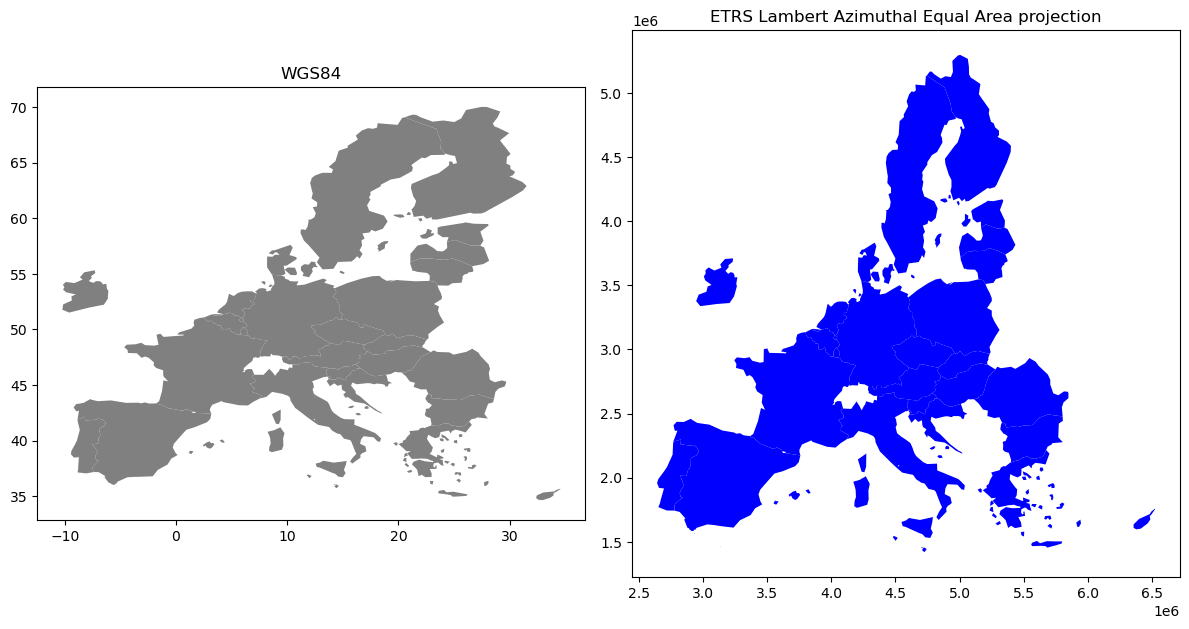

In [27]:
import matplotlib.pyplot as plt

# Make subplots that are next to each other
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 12))

# Plot the data in WGS84 CRS
data_wgs84.plot(ax=ax1, facecolor="gray")

# Add title
ax1.set_title("WGS84")

# Plot the one with ETRS-LAEA projection
data.plot(ax=ax2, facecolor="blue")

# Add title
ax2.set_title("ETRS Lambert Azimuthal Equal Area projection")

# Set aspect ratio as 1
ax1.set_aspect(aspect=1)
ax2.set_aspect(aspect=1)

# Remove empty white space around the plot
plt.tight_layout()

_**Figure 6.12**. Map of Europe plotted with two different coordinate reference systems._

As we can see from the **Figure 6.12**, the maps look quite different and the reprojected one looks significantly better especially in the North where the geometries are more realistic and not so stretched as in WGS84. Finally, let's save our projected layer into a Shapefile so that we can use it later. Note, even if the CRS information is stored with the output file (in this case into a `.prj` file associated with the Shapefile), it might be a good idea also to include CRS info in the filename which makes it easy to identify the CRS directly from the name of the file:

In [28]:
# Ouput filepath
outfp = "data/EU_countries/Europe_borders_epsg3035.shp"

# Save to disk
data.to_file(outfp)

## Advanced CRS functionalities

As the CRS in different spatial datasets differ fairly often (i.e. one might have coordinates defined in decimal degrees while the other one has them in meters), it is a common procedure to reproject (transform) different layers into a common CRS. It is important that the layers are in the same coordinate reference system when analyzing the spatial relationships between the layers, for example, when making a Point in Polygon -query, or other type of overlay analysis.

### Overview

The following code cell prints out a summary summary of different ways of representing crs information using pyproj CRS. Here, we use the crs of the original European borders layer as a starting point:

In [29]:
### Import CRS class from pyproj
from pyproj import CRS

In [30]:
# PROJ dictionary:
crs_dict = data_wgs84.crs

# pyproj CRS object:
crs_object = CRS(data_wgs84.crs)

# EPSG code (here, the input crs information is a bit vague so we need to lower the confidence threshold)
crs_epsg = CRS(data_wgs84.crs).to_epsg(min_confidence=25)

# PROJ string
crs_proj4 = CRS(data_wgs84.crs).to_proj4()

# Well-Known Text (WKT)
crs_wkt = CRS(data_wgs84.crs).to_wkt()

/home/hentenka/.conda/envs/mamba/envs/python-gis-book/lib/python3.10/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


In [31]:
print("PROJ dictionary:\n", crs_dict)
print("\nCRS object:\n", crs_object)
print("\nEPSG code: \n", crs_epsg)
print("\nPROJ string: \n", crs_proj4)
print("\nWell-Known Text (WKT):\n", crs_wkt)

PROJ dictionary:
 EPSG:4326

CRS object:
 GEOGCRS["WGS 84",ENSEMBLE["World Geodetic System 1984 ensemble",MEMBER["World Geodetic System 1984 (Transit)"],MEMBER["World Geodetic System 1984 (G730)"],MEMBER["World Geodetic System 1984 (G873)"],MEMBER["World Geodetic System 1984 (G1150)"],MEMBER["World Geodetic System 1984 (G1674)"],MEMBER["World Geodetic System 1984 (G1762)"],MEMBER["World Geodetic System 1984 (G2139)"],ELLIPSOID["WGS 84",6378137,298.257223563,LENGTHUNIT["metre",1]],ENSEMBLEACCURACY[2.0]],PRIMEM["Greenwich",0,ANGLEUNIT["degree",0.0174532925199433]],CS[ellipsoidal,2],AXIS["geodetic latitude (Lat)",north,ORDER[1],ANGLEUNIT["degree",0.0174532925199433]],AXIS["geodetic longitude (Lon)",east,ORDER[2],ANGLEUNIT["degree",0.0174532925199433]],USAGE[SCOPE["Horizontal component of 3D system."],AREA["World."],BBOX[-90,-180,90,180]],ID["EPSG",4326]]

EPSG code: 
 4326

PROJ string: 
 +proj=longlat +datum=WGS84 +no_defs +type=crs

Well-Known Text (WKT):
 GEOGCRS["WGS 84",ENSEMBLE["Wor

### Pyproj CRS object

Next, let's see how it is possible to easily extract useful information from CRS, and transform CRS information from format to another. `pyproj` -library has a [class](https://docs.python.org/3/tutorial/classes.html) called [CRS](https://pyproj4.github.io/pyproj/dev/api/crs.html) that provides many useful functionalities for dealing with CRS information.

In [32]:
# Let's see the current CRS of our data
print(data.crs)

EPSG:3035


Printing the crs using the print() statement gives us the EPSG code. 

However, let's see how the same information looks like in other formats such as `WKT` or `Proj4` text. For this we need to use the `CRS` class.  

In [33]:
# Initialize the CRS class for epsg code 3035:
crs_object = CRS.from_epsg(3035)
crs_object

<Derived Projected CRS: EPSG:3035>
Name: ETRS89-extended / LAEA Europe
Axis Info [cartesian]:
- Y[north]: Northing (metre)
- X[east]: Easting (metre)
Area of Use:
- name: Europe - European Union (EU) countries and candidates. Europe - onshore and offshore: Albania; Andorra; Austria; Belgium; Bosnia and Herzegovina; Bulgaria; Croatia; Cyprus; Czechia; Denmark; Estonia; Faroe Islands; Finland; France; Germany; Gibraltar; Greece; Hungary; Iceland; Ireland; Italy; Kosovo; Latvia; Liechtenstein; Lithuania; Luxembourg; Malta; Monaco; Montenegro; Netherlands; North Macedonia; Norway including Svalbard and Jan Mayen; Poland; Portugal including Madeira and Azores; Romania; San Marino; Serbia; Slovakia; Slovenia; Spain including Canary Islands; Sweden; Switzerland; Turkey; United Kingdom (UK) including Channel Islands and Isle of Man; Vatican City State.
- bounds: (-35.58, 24.6, 44.83, 84.73)
Coordinate Operation:
- name: Europe Equal Area 2001
- method: Lambert Azimuthal Equal Area
Datum: Europ

As we can see, the `CRS` object contains a of information about the coordinate reference system such as the `Name` of the CRS (ETRS89/LAEA Europe), the `area` where the CRS is in use (*Europe* with bounds *(-16.1, 32.88, 40.18, 84.17)*), and the `Datum` (European Terrestrial Reference System 1989). 

We can also easily parse this information individually as follows: 

In [34]:
# Name
print("Name:", crs_object.name)

# Coordinate system
print("Coordinate system:", crs_object.coordinate_system)

# Bounds of the area where CRS is used
print("Bounds:", crs_object.area_of_use.bounds)

Name: ETRS89-extended / LAEA Europe
Coordinate system: cartesian
Bounds: (-35.58, 24.6, 44.83, 84.73)


You can explore all the possible information that can be extracted from the CRS by typing `crs_object.` and pressing Tabulator. 

Let's see how we can convert the crs information from one format to another. Quite often it is useful to know the EPSG code of the CRS. Next, we will conduct a few transformations to demonstrate the capabilities of the `CRS` class.

In [35]:
# Retrive CRS information in WKT format
crs_wkt = crs_object.to_wkt()
print(crs_wkt)

PROJCRS["ETRS89-extended / LAEA Europe",BASEGEOGCRS["ETRS89",ENSEMBLE["European Terrestrial Reference System 1989 ensemble",MEMBER["European Terrestrial Reference Frame 1989"],MEMBER["European Terrestrial Reference Frame 1990"],MEMBER["European Terrestrial Reference Frame 1991"],MEMBER["European Terrestrial Reference Frame 1992"],MEMBER["European Terrestrial Reference Frame 1993"],MEMBER["European Terrestrial Reference Frame 1994"],MEMBER["European Terrestrial Reference Frame 1996"],MEMBER["European Terrestrial Reference Frame 1997"],MEMBER["European Terrestrial Reference Frame 2000"],MEMBER["European Terrestrial Reference Frame 2005"],MEMBER["European Terrestrial Reference Frame 2014"],ELLIPSOID["GRS 1980",6378137,298.257222101,LENGTHUNIT["metre",1]],ENSEMBLEACCURACY[0.1]],PRIMEM["Greenwich",0,ANGLEUNIT["degree",0.0174532925199433]],ID["EPSG",4258]],CONVERSION["Europe Equal Area 2001",METHOD["Lambert Azimuthal Equal Area",ID["EPSG",9820]],PARAMETER["Latitude of natural origin",52,ANGL

As we can see, the `WKT` format contains a *lot* of information. Typically, e.g. the `.prj` file of a Shapefile contains the information in this format. Let's see how it is possible to extract `EPSG` code from this. For doing it, we need to re-initialize the CRS object, this time from the `WKT` text presentation.   

In [36]:
# Retrieve EPSG code from WKT text
epsg = CRS(crs_wkt).to_epsg()
print(epsg)

3035


<div class="alert alert-info">

**Not able to recognize epsg?**
    
Sometimes `to_epsg()` isn't able to recognize the EPSG code from the WKT representation. This can happen if the WKT information is missing some details. Luckily, we can easily adjust the minimum level of confidence for matching the CRS info and the EPSG code. We can do this by adjusting a parameter `min_confidence` when calling the function. By default, the confidence level is 70 %, but it is also possible to set a lower confidence threshold. 
    
The coordinate information of our input shapefile is incomplete, and does not yield an epsg value with default setting: However, CRS is able to determine the EPSG value with a lower confidence treshold: 
    
```
# Let's try to extract the EPSG code from the crs of our original data:
CRS(data.crs).to_epsg()
>>> None
    
# Let's try it again with a lower confidence requirement (25 %)
CRS(data.crs).to_epsg(min_confidence=25)
>>> 3035
```
However, be cautious when using this, as guessing the EPSG from "exotic" coordinate reference systems might also provide false results. 
</div>

Let's now save our data to disk using the `WKT` format as the crs of our GeoDataFrame. WKT is a [preferred output format](https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems) when storing crs information as text.

In [37]:
# Re-define the CRS of the input GeoDataFrame
data.crs = CRS.from_epsg(3035).to_wkt()

In [38]:
print(data.crs)

PROJCRS["ETRS89-extended / LAEA Europe",BASEGEOGCRS["ETRS89",ENSEMBLE["European Terrestrial Reference System 1989 ensemble",MEMBER["European Terrestrial Reference Frame 1989"],MEMBER["European Terrestrial Reference Frame 1990"],MEMBER["European Terrestrial Reference Frame 1991"],MEMBER["European Terrestrial Reference Frame 1992"],MEMBER["European Terrestrial Reference Frame 1993"],MEMBER["European Terrestrial Reference Frame 1994"],MEMBER["European Terrestrial Reference Frame 1996"],MEMBER["European Terrestrial Reference Frame 1997"],MEMBER["European Terrestrial Reference Frame 2000"],MEMBER["European Terrestrial Reference Frame 2005"],MEMBER["European Terrestrial Reference Frame 2014"],ELLIPSOID["GRS 1980",6378137,298.257222101,LENGTHUNIT["metre",1]],ENSEMBLEACCURACY[0.1]],PRIMEM["Greenwich",0,ANGLEUNIT["degree",0.0174532925199433]],ID["EPSG",4258]],CONVERSION["Europe Equal Area 2001",METHOD["Lambert Azimuthal Equal Area",ID["EPSG",9820]],PARAMETER["Latitude of natural origin",52,ANGL

That's it. 


**HINT**: A module called [PyCRS](https://github.com/karimbahgat/PyCRS) can also be useful library as it contains information and supports many different coordinate reference definitions, such as OGC WKT (v1), ESRI WKT, Proj4, and any EPSG, ESRI, or SR-ORG code available from spatialreference.org.

## Global map projections

Finally, let's play around with global map projections :) `L2_data` folder conaints a layer `ne_110m_admin_0_countries.shp` that represents the country borders of the world. The data was fownloaded from https://www.naturalearthdata.com/. 

#### Check your understanding

<div class="alert alert-info">

    
Read in a global dataset and plot three maps with different projections! See hints and projection definitions from:
    
- http://geopandas.org/projections.html
- https://pyproj4.github.io/pyproj/dev/api/crs.html
- https://spatialreference.org/
    
When plotting the maps, think about the advantages and disadvantages of different world map projections.
   
</div>


In [ ]:
# Read in data
fp = "L2_data/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp"
admin = gpd.read_file(fp)

In [ ]:
# Check input crs
admin.crs

In [ ]:
# Set fig size
plt.rcParams["figure.figsize"] = [12, 6]

In [ ]:
# Plot in original crs
admin.plot()
plt.title("WGS84")

_**Figure 6.X**. Global map plotted in WGS 84._

In [ ]:
# Define projection as web mercator, 3785
web_mercator = CRS.from_epsg(3785)

# Re-project and plot
admin.to_crs(web_mercator).plot()

# Remove x and y axis
plt.axis("off")
plt.title("Web mercator")

_**Figure 6.X**. Global map plotted in Web Mercator._

_**Figure 6.X**. Global map plotted in Eckert IV._

In [ ]:
# Define an orthographic projection, centered in Finland! from: http://www.statsmapsnpix.com/2019/09/globe-projections-and-insets-in-qgis.html
ortho = CRS.from_proj4(
    "+proj=ortho +lat_0=60.00 +lon_0=23.0000 +x_0=0 +y_0=0 +a=6370997 +b=6370997 +units=m +no_defs"
)

# Re-project and plot
admin.to_crs(ortho).plot()

# Remove x and y axis
plt.axis("off")
plt.title("Orthographic")

_**Figure 6.X**. Global map plotted in an orthographic projection._

## Summary
That's it! In this section we learned how to:

1. reproject (transform) the geometries from crs to another using the `to_crs()` -function in GeoPandas
2. Define the coordinate reference system in different formats using `pyproj` `CRS`

## Footnotes

[^proj]: <https://proj.org/>
[^pyproj]: <https://pyproj4.github.io/pyproj/stable/>
[^EU_projection]: <http://mapref.org/LinkedDocuments/MapProjectionsForEurope-EUR-20120.pdf>
[^LAEA]: <https://spatialreference.org/ref/epsg/etrs89-etrs-laea/>